# Individual Analysis

This notebooks aims at exploring the data on an Indiviudal LEvel: checking a single subject for their validity! 


### Load and Preprocess Participant Raw Data

This code Gets the data a specific filename and Loads it as a RawDF
as well as events getting specific strctutes for Saccade, blinks and Fizations, as well as my Own Events 

In [1]:
import numpy as np
from analysisFunctions import *
import os 
import pandas as pd

filename = "ADga2904"
verbose  = 1;

pd.set_option("display.max_rows",10)
workingDir = os.getcwd();
if os.path.isdir(os.path.join(workingDir,filename)) == 0:
    os.makedirs(os.path.join(workingDir,filename))
path = os.path.split(workingDir)[0] + "\\data"
log_file = open(os.path.join(workingDir,filename,filename+"_preprocLog.txt"),'w+')


log_file.write(" "*15+"="*58 + "\n")
log_file.write(" "*15+"="*5+ " "*15+" PREPROC LOG FILE"+ " "*15+"="*5+ " \n")
log_file.write(" "*15+"="*58 + "\n\n")
log_file.write("\n===# Load and Prepare Data #=== \n\n")

### Load Particpant data getting Events Raw EyeData and My owb events as well as Screen Coordinates 
log_file.write("    Loading Participant Data... ")

[own,rawEye, events, gazeCoords] = loadParticipant(path, name=filename) # Gets my RawEye Data as well as events and gaze Coordination
RawDF = pd.DataFrame(rawEye,columns=["TimePoint",'LeftX','LeftY','LeftPupil','RightX','RightY','RightPupil']);
log_file.write("done \n")

# Get Events
log_file.write("    Getting Events...           ")
fixationDF,saccadesDF,blinkDF = getEvent(events)
log_file.write("done \n")

# Change Timing so it will be relative from the start of the experiment
log_file.write("    Changing Timing....         ")
RawDF,fixationDF,saccadesDF,blinkDF,own = changeTiming(RawDF,fixationDF,saccadesDF,blinkDF,own)
log_file.write("done \n")

# Parse your own events getting a Wide format getting only PARTS with their Timing  (Maybe Write Checks?)
log_file.write("    Getting Own Events...       ")
event_dfs = parse_events(own)
event_dfs = rename_parts(event_dfs) # Be sure that the numeration for each entity part is Correct! 
log_file.write("done \n")
if len(event_dfs) != 40:
    log_file.write("    WARNING! the events are not whole!       ")
log_file.write("\n            Events DataFrame:       \n")

log_file.write(event_dfs.describe().to_string())
# Contains All our Data but now Comnvienientl Split for a stories 
log_file.write("\n\n    Splitting by events...      ")
split_data = split_dataframes_by_events(RawDF, fixationDF, saccadesDF, blinkDF, event_dfs)
log_file.write("done \n")

if verbose:
    for splt in split_data.keys():
        for event_name, df in split_data[splt]['RawDF'].items():
            if verbose:
                print(df)
        for event_name, df in split_data[splt]['fixationDF'].items():
            print(f"    fixationDF for {event_name}:")
            if verbose:
                print(df)
        for event_name, df in split_data[splt]['saccadesDF'].items():
            print(f"    saccadesDF for {event_name}:")
            if verbose:
                print(df)
        for event_name, df in split_data[splt]['blinkDF'].items():
            print(f"    blinkDF for {event_name}:")
            if verbose:
                print(df)


       TimePoint  LeftX  LeftY  LeftPupil  RightX  RightY  RightPupil
61         122.0  899.2  669.2     4663.0   914.3   657.4      4585.0
62         124.0  899.2  666.6     4647.0   915.0   654.1      4584.0
63         126.0  896.9  663.2     4636.0   913.6   650.3      4568.0
64         128.0  896.9  661.5     4632.0   911.7   650.0      4561.0
65         130.0  898.6  660.7     4628.0   908.2   650.0      4557.0
...          ...    ...    ...        ...     ...     ...         ...
21342    42684.0  948.3  559.6     6548.0  1013.7   558.3      6238.0
21343    42686.0  946.7  560.0     6548.0  1012.6   558.3      6237.0
21344    42688.0  946.0  559.6     6546.0  1012.3   559.3      6234.0
21345    42690.0  946.8  558.4     6545.0  1011.8   559.5      6234.0
21346    42692.0  946.8  558.9     6542.0  1012.1   559.0      6232.0

[21286 rows x 7 columns]
       TimePoint   LeftX  LeftY  LeftPupil  RightX  RightY  RightPupil
26164    52328.0   955.2  692.5     5065.0   966.4   693.2     

In [2]:
### Get the Tracked Entity Name:

with open(os.path.join(path, filename,filename + '_log.txt'), 'r') as fp:
    for line in fp:
        if "Current Named Entity" in line:
            entityTracked = line.split("Current Named Entity: ")[1].strip()
            break

print(entityTracked)

KAROLINA


### General Data Overview: 

#### Plot Unfiltered Data: Irregardless of the Trial Validity: 

In [28]:
###  Plot Raw Data

log_file.write("\n===# Stats and Checks for Unfiltered Data #=== \n\n ")


def GeneralChecks(RawDF, blinkDF, saccadesDF, fixationDF, gazeCoords):
    """
    General Checks for the Raw Data
    """

    # Check if the data is in the right format
    if not isinstance(RawDF, pd.DataFrame):
        raise ValueError("RawDF should be a pandas DataFrame")
    if not isinstance(blinkDF, pd.DataFrame):
        raise ValueError("blinkDF should be a pandas DataFrame")
    if not isinstance(saccadesDF, pd.DataFrame):
        raise ValueError("saccadesDF should be a pandas DataFrame")
    if not isinstance(fixationDF, pd.DataFrame):
        raise ValueError("fixationDF should be a pandas DataFrame")
    

    from analysisFunctions import eyeRawKDE,plotRawGaze
    import matplotlib.pyplot as plt 

    #. Check whether Majority of Gaze Positions Lay in the center
    print("\n(1) Check mean Gaze Center\n")
    log_file.write("\n(1) Check mean Gaze Center\n")

    print("                              X          Y")
    log_file.write("                              X           Y\n")
    print(f"Middle Screen Coordinates: {(gazeCoords[2] / 2):6.1f}      {gazeCoords[3] / 2:6.1f}")
    log_file.write(f"Middle Screen Coordinates: {(gazeCoords[2] / 2):6.1f}      {gazeCoords[3] / 2:6.1f}\n")
    print(f"Mean Eye Coordinates:      {np.mean(RawDF['LeftX']):5.1f}       {np.mean(RawDF['LeftY']):5.1f}")
    log_file.write(f"Mean Eye Coordinates:      {np.mean(RawDF['LeftX']):5.1f}       {np.mean(RawDF['LeftY']):5.1f}\n")

    # 1. Check if there are Too Many Missing data from One Eye
    print("\n(2) Check Missing Pupil Data as a proxy for missing!\n")
    log_file.write("\n(2) Check Missing Pupil Data as a proxy for missing!\n")
    zeroPupilLeft = RawDF[RawDF['LeftPupil'] == 0]
    zeroPupilRight = RawDF[RawDF['RightPupil'] == 0]
    zeroPupilBoth = RawDF[(RawDF['RightPupil'] == 0) & (RawDF['LeftPupil'] == 0)]
    print(f"Number of NoGaze Data: \n(Left: {len(zeroPupilLeft)}, Right: {len(zeroPupilRight)}), Both: {len(zeroPupilBoth)}")
    log_file.write(f"Number of NoGaze Data: \n(Left: {len(zeroPupilLeft)}, Right: {len(zeroPupilRight)}), Both: {len(zeroPupilBoth)}\n")

    log_file.write("\n"+"-"*100 + "\n")


    # (1) Mismatch between Pupil Diameters Left to Right 
    # Get raw when all data are greater than 0 (no blinks) 
    RawDFPupilTrue = RawDF[(RawDF['LeftPupil'] > 0) & (RawDF['RightPupil'] > 0)]
    pupilDifference = (RawDFPupilTrue['LeftPupil'] - RawDFPupilTrue['RightPupil']) / RawDFPupilTrue['LeftPupil']

    print("\n (3) Pupil Difference Test \n")
    log_file.write("\n (3) Pupil Difference Test \n")
    print(f"    Percentage Difference: {np.mean(pupilDifference)}")
    log_file.write(f"    Percentage Difference: {np.mean(pupilDifference)}\n")


    return RawDFPupilTrue,log_file


#[RawDFPupilTrue,log_file] = GeneralChecks(RawDF, blinkDF, saccadesDF, fixationDF, gazeCoords)


#### Plot General Data only relevant to trials: 



In [4]:

def splitEntities(RawDF, event_dfs):
    """
    Splits the RawDF into two entities based on the events DataFrame.
    """
    firstEntityRaw  = []
    secondEntityRaw = []

    for i in range(len(event_dfs)):

        currentTiming1 = event_dfs['beg'].iloc[i]
        currentTiming2 = event_dfs['end'].iloc[i]

        if 'TimePoint' in RawDF.columns:
            RawDF1 = RawDF[(RawDF['TimePoint'] >= currentTiming1) & (RawDF['TimePoint'] <= currentTiming2)]
        elif 'Beg' in RawDF.columns:
            RawDF1 = RawDF[(RawDF['Beg'] >= currentTiming1) & (RawDF['End'] <= currentTiming2)]

        if i %2 ==0:
            firstEntityRaw.append(RawDF1)
        else:
            secondEntityRaw.append(RawDF1)

    firstEntityDF = pd.concat(firstEntityRaw, ignore_index=True)
    secondEntityDF = pd.concat(secondEntityRaw, ignore_index=True)

    return firstEntityDF, secondEntityDF


[firstEntityRaw, secondEntityRaw] = splitEntities(RawDF, event_dfs)
[firstEntityBlinks, secondEntityBlinks] = splitEntities(blinkDF, event_dfs)
[firstEntitySaccades, secondEntitySaccades] = splitEntities(saccadesDF, event_dfs)
[firstEntityFixation, secondEntityFixation] = splitEntities(fixationDF, event_dfs)



(1) Check mean Gaze Center

                              X          Y
Middle Screen Coordinates:  959.5       539.5
Mean Eye Coordinates:      1066.5       597.2

(2) Check Missing Pupil Data as a proxy for missing!

Number of NoGaze Data: 
(Left: 93456, Right: 63191), Both: 61987

 (3) Pupil Difference Test 

    Percentage Difference: 0.032616299123262464


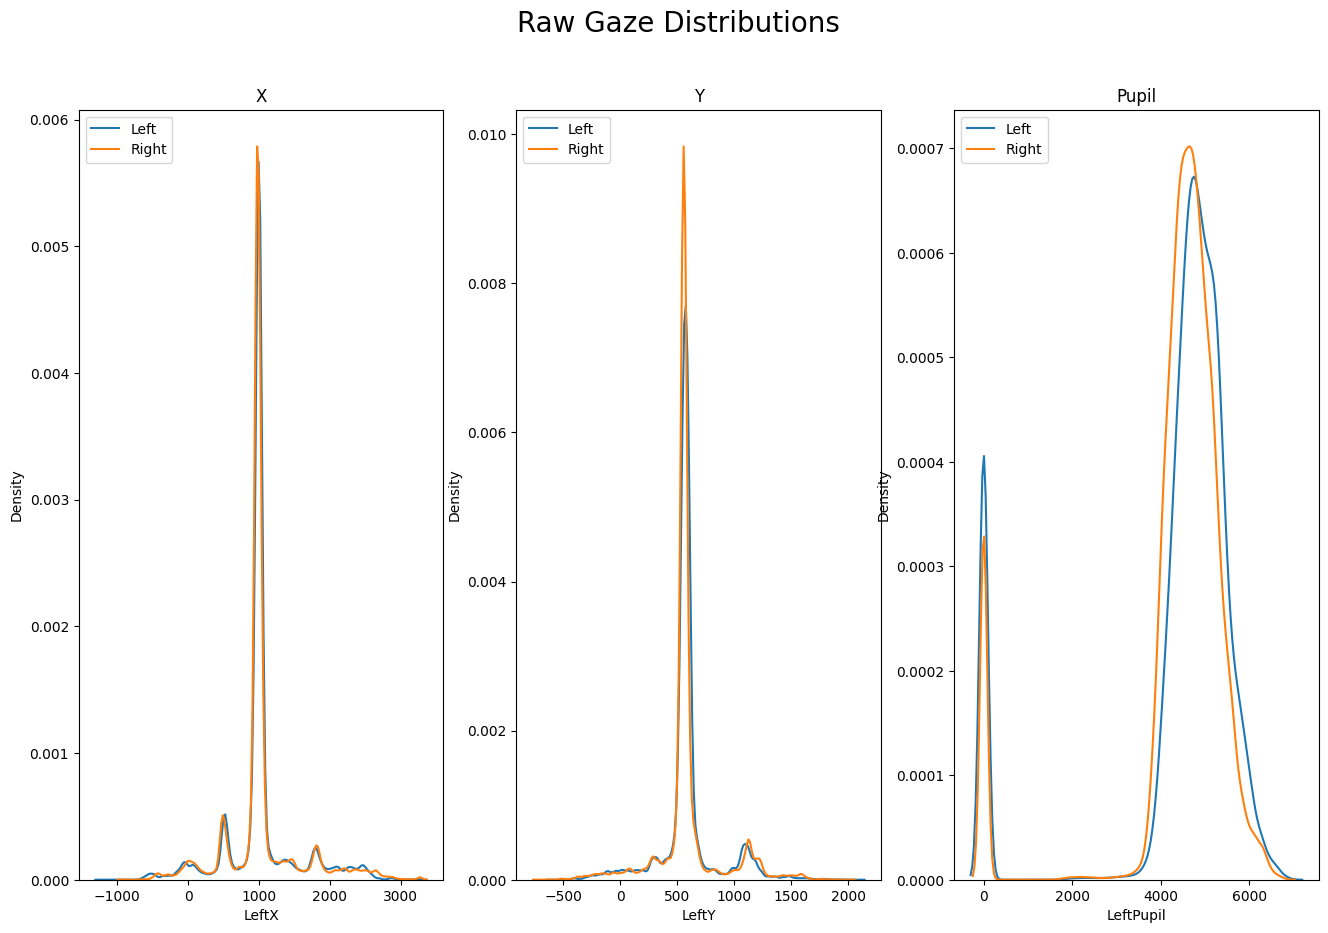

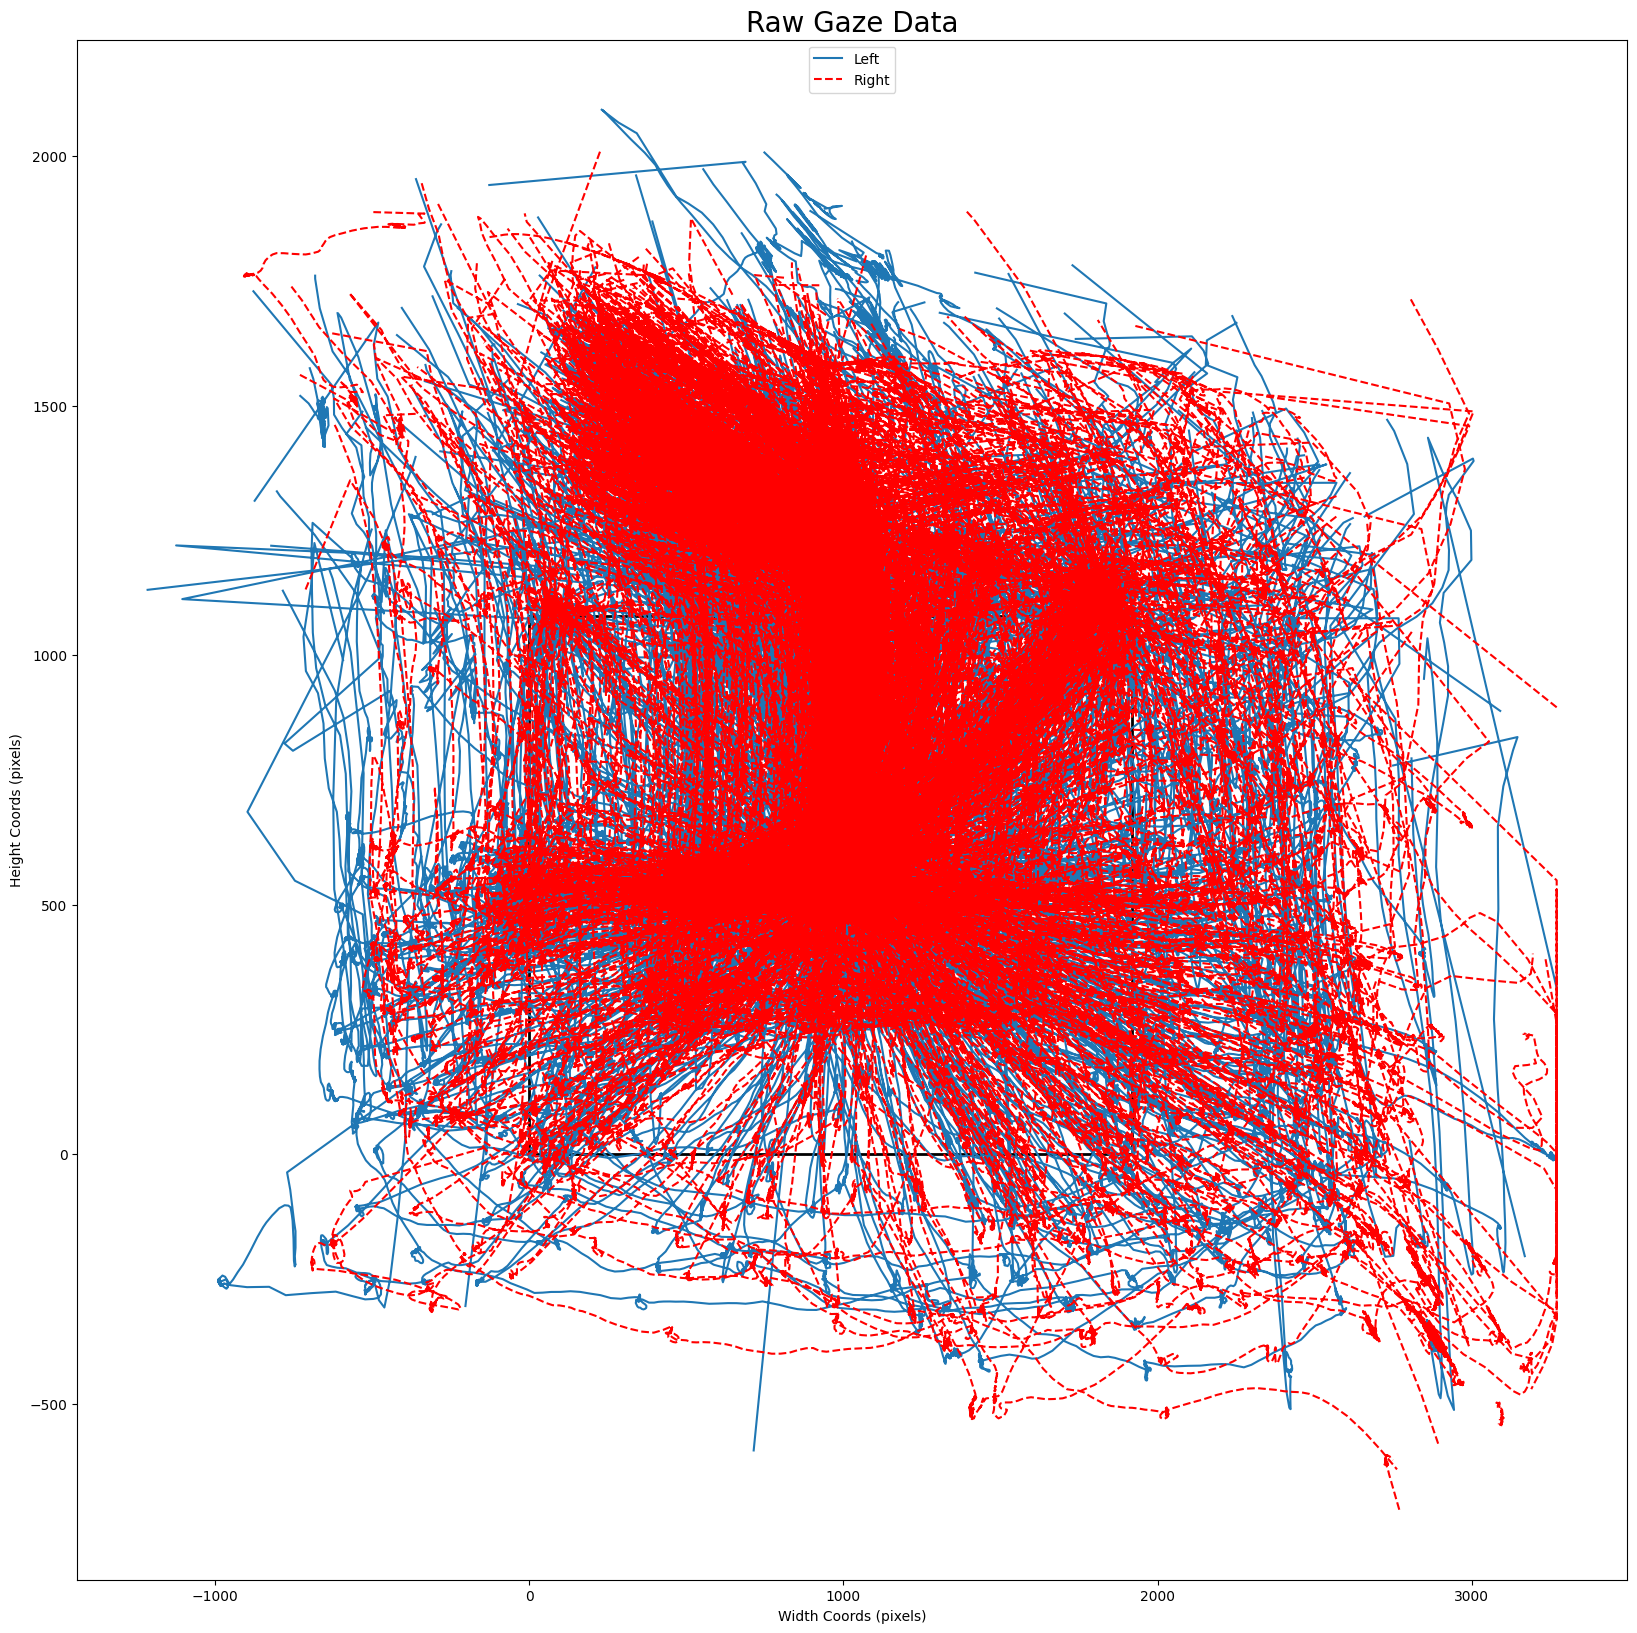

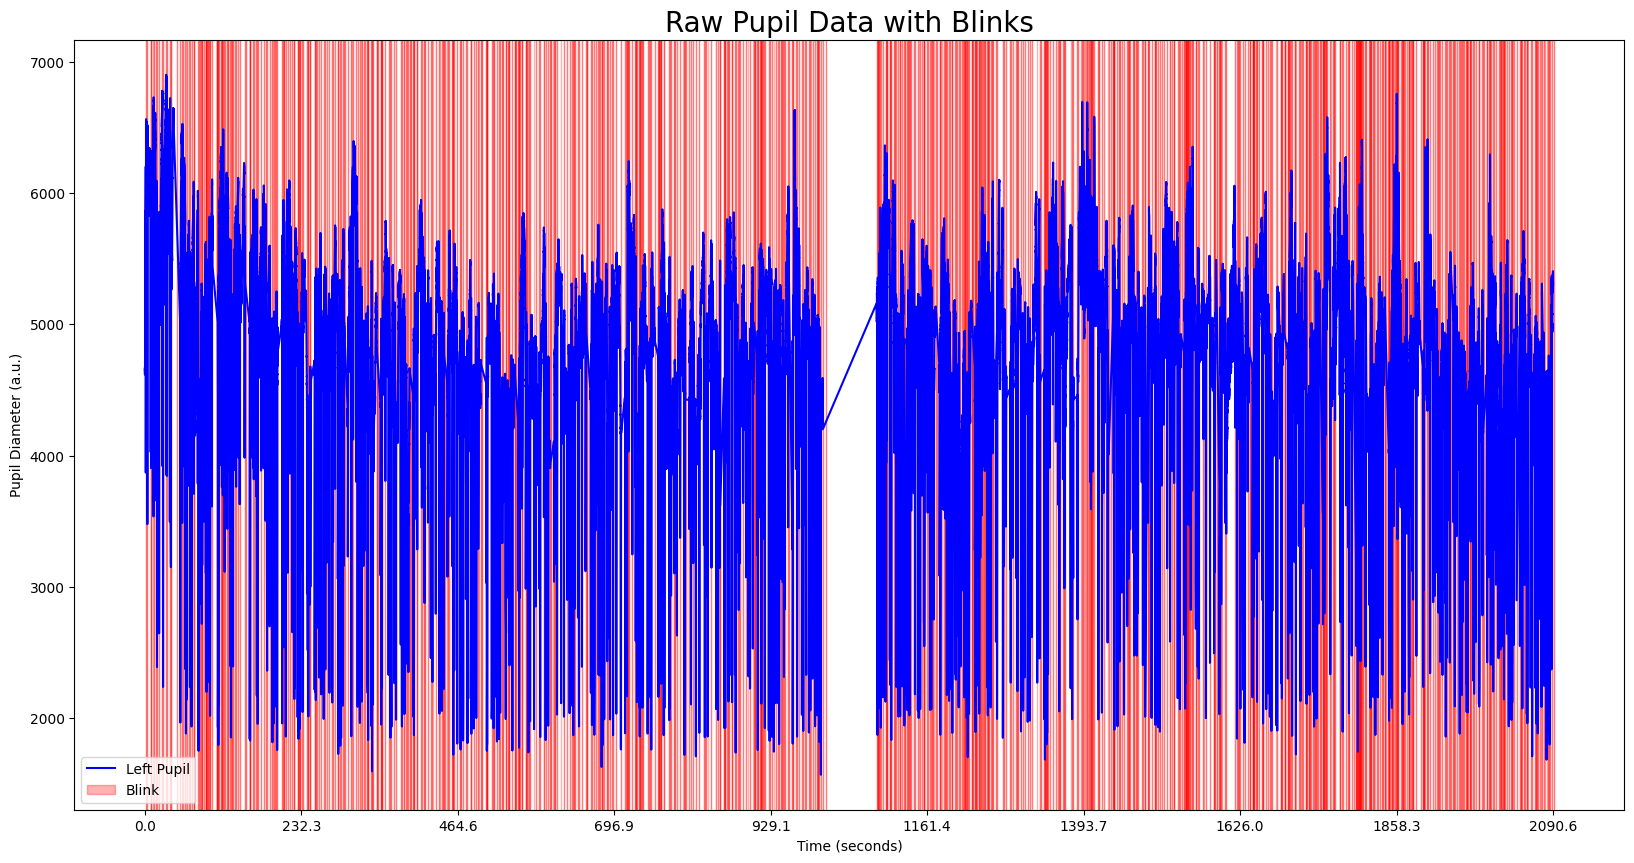

In [5]:


allEntities = pd.concat([firstEntityRaw, secondEntityRaw], ignore_index=True)
allEntities.sort_values(by='TimePoint', inplace=True)

log_file.write("\n===# Stats and Checks for Experiment Relevant only Data #=== \n\n ")

[RawDFPupilTrue,log_file] = GeneralChecks(allEntities, blinkDF, saccadesDF, fixationDF, gazeCoords)




fig1 = eyeRawKDE(RawDF)
plt.savefig(os.path.join(workingDir,filename,filename+"_Distribution_filt.png"))
plotRawGaze(RawDF,gazeCoords)
plt.savefig(os.path.join(workingDir,filename,filename+"_RawGaze_filt.png"))
plotPupilTimecourse(RawDFPupilTrue, "Raw Pupil Data with Blinks", blinkDF, saccadesDF, fixationDF, chooseViz='001')
plt.savefig(os.path.join(workingDir,filename,filename+"_RawPupil_filt.png"))

In [6]:
from matplotlib.backends.backend_pdf import PdfPages
output_dir =os.path.join(workingDir,filename)

pdf_path_raweyegaze = os.path.join(output_dir, "RawEyeGaze.pdf")
pdf_raweyegaze = PdfPages(pdf_path_raweyegaze)

fig1 = eyeRawKDE(RawDF,titl=filename)
pdf_raweyegaze.savefig(fig1)
plt.close(fig1)


In [7]:
pdf_raweyegaze.close()

### Data Quality Metrics for a particpant

Including (For Each Entity and Halve of experiment)
+ Blink Rate 
+ Rate of Outside of Screen Events
+ Mean Gaze Deviation (mean + sd)
+ Mean and SD Saccade
+ Mean and SD Pupil Diameter
+ Mean and SD Left-Right Deviation 

In [29]:
def qualiryMetrics(RawDFs, saccadesDFs, blinkDFs, gazeCoords, log_file=None,verbose=1):
    nogazeRate = np.empty([2, 2])
    gazeDiff = np.empty([2, 2])
    pupilDiff = np.empty([2, 2])
    saccDiff = np.empty([2, 2])
    blinkDiff = np.empty([2, 2])
    eyeposDiff = np.empty([2, 2])

    for i in range(len(RawDFs)):
        df = RawDFs[i]

        for j, LR in enumerate(['Left', 'Right']):
            # Gaze center distance
            dx = gazeCoords[2] / 2 - np.mean(df[LR + 'X'])
            dy = gazeCoords[3] / 2 - np.mean(df[LR + 'Y'])
            gazeDiff[i, j] = np.sqrt(dx**2 + dy**2)

            # No gaze data ratio
            zeroPupil = df[df[LR + 'Pupil'] == 0]
            nogazeRate[i, j] = len(zeroPupil) / len(df)

            # Saccade and blink counts
            saccDiff[i, j] = np.sum(saccadesDFs[i]['Eye'] == LR[0])
            blinkDiff[i, j] = np.sum(blinkDFs[i]['Eye'] == LR[0])

        # Pupil difference
        pupilValid = df[(df['LeftPupil'] > 0) & (df['RightPupil'] > 0)]
        pupilDiff[i, 0] = len(pupilValid['LeftPupil'])
        pupilDiff[i, 1] = len(pupilValid['RightPupil'])
        pupil_rel_diff = (pupilValid['LeftPupil'] - pupilValid['RightPupil']) / pupilValid['LeftPupil']
        pupil_mean = np.mean(pupil_rel_diff)
        pupil_std = np.std(pupil_rel_diff)

        # Eye position mismatch
        eye_diff = abs(df['LeftX'] - df['RightX'])
        mean_eye_diff = np.mean(eye_diff)
        std_eye_diff = np.std(eye_diff)
        eyeposDiff[i, 0] = len(df['LeftX'])
        eyeposDiff[i, 1] = len(df['RightX'])

        if verbose and log_file is not None: 

            # === LOG & PRINT ===
            print(f"\n({i+1}) Quality Metrics for Entity {i+1}:\n")
            log_file.write(f"\n(1) Quality Metrics for Entity {i+1}:\n")

            # Define fixed width formatting
            def fmt(val): return f"{val:>10.5f}"
            def fmt_int(val): return f"{val:>10}"
            print(f"{'Metric':<30} {'Left':>10} {'Right':>10}")
            log_file.write(f"{'Metric':<30} {'Left':>10} {'Right':>10}\n")

            print(f"{'Coordinate Difference:':<30} {fmt(gazeDiff[i, 0])} {fmt(gazeDiff[i, 1])}")
            log_file.write(f"{'Coordinate Difference:':<30} {fmt(gazeDiff[i, 0])} {fmt(gazeDiff[i, 1])}\n")

            print(f"{'Rate of No Gaze Data:':<30} {fmt(nogazeRate[i, 0])} {fmt(nogazeRate[i, 1])}")
            log_file.write(f"{'Rate of No Gaze Data:':<30} {fmt(nogazeRate[i, 0])} {fmt(nogazeRate[i, 1])}\n")

            print(f"{'Saccade Count:':<30} {fmt_int(int(saccDiff[i, 0]))} {fmt_int(int(saccDiff[i, 1]))}")
            log_file.write(f"{'Saccade Count:':<30} {fmt_int(int(saccDiff[i, 0]))} {fmt_int(int(saccDiff[i, 1]))}\n")

            print(f"{'Blink Count:':<30} {fmt_int(int(blinkDiff[i, 0]))} {fmt_int(int(blinkDiff[i, 1]))}\n")
            log_file.write(f"{'Blink Count:':<30} {fmt_int(int(blinkDiff[i, 0]))} {fmt_int(int(blinkDiff[i, 1]))}\n\n")

            print(f"{'Pupil Relative Diff (L-R):':<30} {pupil_mean:>10.5f} (±{pupil_std:.5f})")
            log_file.write(f"{'Pupil Relative Diff (L-R):':<30} {pupil_mean:>10.5f} (±{pupil_std:.5f})\n")

            print(f"{'Eye Position Mismatch (X):':<30} {mean_eye_diff:>10.5f} (±{std_eye_diff:.5f})\n")
            log_file.write(f"{'Eye Position Mismatch (X):':<30} {mean_eye_diff:>10.5f} (±{std_eye_diff:.5f})\n\n")

    return gazeDiff, pupilDiff, saccDiff, blinkDiff, eyeposDiff, nogazeRate,pupil_mean,mean_eye_diff

gazeDiff, pupilDiff, saccDiff, blinkDiff, eyeposDiff, nogazeRate,_,_ = qualiryMetrics([firstEntityRaw, secondEntityRaw], [firstEntitySaccades, secondEntitySaccades], [firstEntityBlinks, secondEntityBlinks], gazeCoords, log_file)





NameError: name 'firstEntityRaw' is not defined

#### Data Quality differentiated between parts of Experiment

In [30]:

def chooseFirstSecondHalf(firstEntityRaw):

    if 'TimePoint' in firstEntityRaw.columns:
        firstEntityRaw1       =  firstEntityRaw[firstEntityRaw['TimePoint']  < np.median(firstEntityRaw['TimePoint'])]
        firstEntityRaw2       =  firstEntityRaw[firstEntityRaw['TimePoint'] > np.median(firstEntityRaw['TimePoint'])]

    elif 'Beg' in firstEntityRaw.columns:
        firstEntityRaw1       =  firstEntityRaw[firstEntityRaw['Beg']  < np.median(firstEntityRaw['Beg'])]
        firstEntityRaw2       =  firstEntityRaw[firstEntityRaw['Beg'] > np.median(firstEntityRaw['Beg'])]

    return firstEntityRaw1, firstEntityRaw2


firstEntityRaw1, firstEntityRaw2 = chooseFirstSecondHalf(firstEntityRaw)
secondEntityRaw1, secondEntityRaw2 = chooseFirstSecondHalf(secondEntityRaw)
firstEntityBlinks1, firstEntityBlinks2 = chooseFirstSecondHalf(firstEntityBlinks)
secondEntityBlinks1, secondEntityBlinks2 = chooseFirstSecondHalf(secondEntityBlinks)
firstEntitySaccades1, firstEntitySaccades2 = chooseFirstSecondHalf(firstEntitySaccades)
secondEntitySaccades1, secondEntitySaccades2 = chooseFirstSecondHalf(secondEntitySaccades)

log_file.write("\n===# GeneralCheck Parameters 1st Half #=== \n\n ")
gazeDiff1, pupilDiff1, saccDiff1, blinkDiff1, eyeposDiff1, nogazeRate1,_,_  = qualiryMetrics([firstEntityRaw1, secondEntityRaw1], [firstEntitySaccades1, secondEntitySaccades1], [firstEntityBlinks1, secondEntityBlinks1], gazeCoords, log_file)

log_file.write("\n===#  GeneralCheck Parameters 2st Half  #=== \n\n ")
gazeDiff2, pupilDiff2, saccDiff2, blinkDiff2, eyeposDiff2, nogazeRate2,_,_  = qualiryMetrics([firstEntityRaw2, secondEntityRaw2], [firstEntitySaccades2, secondEntitySaccades2], [firstEntityBlinks2, secondEntityBlinks2], gazeCoords, log_file)

NameError: name 'firstEntityRaw' is not defined


#### New Individual Procedure:

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from analysisFunctions import (
    downsamplePupil,
    interpolate_blinks,
    plotPupilTimecourse,
    removeOutliers,
    replace_zero_clusters_with_nans,
    smooth_pupil_data,
    count_gaze_outside,
    plotEyeWithBlink,
    preprocessingPipeline
)

# Other Checks:
storyIndCheck = {}

verbose = 1
resRate = 100
dgvCent = 5
blinkInt = 0;
maxblength = 500
blkboundry = 50
blinkbegbound = 1000
smoothwin = 10
maxcluslen = 2000
mingaplen = 50;
trialOffset = 10000
baseOffset = 0

paramsDict ={verbose:verbose,
            resRate:resRate,
            dgvCent:dgvCent,
            blinkInt:blinkInt,
            maxblength:maxblength,
            blkboundry:blkboundry,
            blinkbegbound:blinkbegbound,
            smoothwin:smoothwin,
            maxcluslen:maxcluslen,
            mingaplen:mingaplen
}
# Define output directory
output_dir =os.path.join(workingDir,filename)

# Define PDF paths
pdf_path_downsampled = os.path.join(output_dir, "Downsampled_Pupil_Data.pdf")
pdf_path_screen_only = os.path.join(output_dir, "Screen_Only.pdf")
pdf_path_blink_rejection = os.path.join(output_dir, "After_Pupil_Artefacts_Rejection.pdf")
pdf_path_outlier_rejection = os.path.join(output_dir, "After_Outlier_Rejection.pdf")
pdf_path_centered = os.path.join(output_dir, "CenteredPupil.pdf")
pdf_path_nan_rejection = os.path.join(output_dir,"NaN_rejected_Pupil.pdf")
# Open PdfPages objects for each PDF

pdf_downsampled = PdfPages(pdf_path_downsampled)
pdf_center_only = PdfPages(pdf_path_screen_only)
pdf_blink_rejection = PdfPages(pdf_path_blink_rejection)
pdf_outlier_rejection = PdfPages(pdf_path_outlier_rejection)

pdf_nan_rejection = PdfPages(pdf_path_nan_rejection)
pdf_smoothed = PdfPages(pdf_path_centered)
log_file.write("\n===# Preprocessing the Data #=== \n\n ")
log_file.write(f"    Preproc Parameters: General: \n")
log_file.write(f"        Verbose:              {verbose}\n")
log_file.write(f"        Resampling Rate:      {resRate}\n")
log_file.write(f"        DGV from Center:      {dgvCent}\n\n")
log_file.write(f"    Preproc Parameters: Blinks: \n")
log_file.write(f"        Blink Interpolation:  {blinkInt}\n")
log_file.write(f"        Maximum Blink Length: {maxblength}\n")
log_file.write(f"        Blink Interp Bound:   {blkboundry}\n")
log_file.write(f"        Blink Begining Bound: {blinkbegbound}\n\n")
log_file.write(f"    Preproc Parameters: Smooth: \n")
log_file.write(f"        Window size:          {smoothwin}\n")
log_file.write(f"        Minimal Cluster len:  {maxcluslen}\n")
log_file.write(f"        Maximal Gap Length:   {mingaplen}\n\n")
# Iterate through events of split_data
data = {};
finalDataStruct = {}
resultsL = np.zeros((len(split_data['STORY_1']['RawDF']), 4))
resultsR = np.zeros((len(split_data['STORY_1']['RawDF']), 4))
iterCounter = 0
for story, data_dict in split_data.items():
    finalDataStruct[story] = {}
    data[story] = {}
    storyIndCheck[story] = {}
    storyIndCheck[story]['goodRatioLeft']      = []
    storyIndCheck[story]['goodRatioRight']     = []
    storyIndCheck[story]['goodPupRatioLeft']   = []
    storyIndCheck[story]['goodPupRatioRight']  = []
    storyIndCheck[story]['gazeDiff']    = []
    storyIndCheck[story]['gazeRate']    = []
    storyIndCheck[story]['pupilDiff']   = []
    storyIndCheck[story]['meanEyeDiff'] = []
    for part, RawDF in data_dict['RawDF'].items():
        print(f"\nAnalysing: {story} // {part} ")
        log_file.write(f"    ### Analysing: {story} // {part} ###\n")
        data[story][part] = {}

        blinkDF = data_dict['blinkDF'][part]
        saccadesDF = data_dict['saccadesDF'][part]


        finalData = preprocessingPipeline(blinkDF,RawDF,saccadesDF,gazeCoords,story,part,log_file=log_file,pdfs=[pdf_downsampled,pdf_center_only,pdf_blink_rejection ,pdf_outlier_rejection ,pdf_nan_rejection,pdf_smoothed],
                                        verbose=verbose,interp_type=blinkInt,interpBoundary=blkboundry,maxBlinkDur=maxblength,resampleRate=resRate,
                                        dgvCenter=dgvCent,smoothwin=smoothwin, min_cluster_duration=maxcluslen,max_gap_duration=mingaplen)
        
        log_file.write("\n        Final Data Stats: \n")
        log_file.write(finalData.describe().to_string().replace('\n', '\n\t\t').join(['\t\t', ''])) # Adds two Tabulations!
        log_file.write("\n\n")
        log_file.write("        Sanity Checks on Final Data: \n")
        log_file.write(f"            Number of Non-missing Data events: {len(finalData['LeftPupil'].dropna())} ({len(finalData['LeftPupil'].dropna())/len(finalData)} %)\n")
        gazeD, _, _, _, _, _,pupil_mean,mean_eye_diff  = qualiryMetrics([finalData], [saccadesDF], [blinkDF], gazeCoords, log_file)
        

        ### Compute mean of last 10s of the data
        meanPupilL = finalData[(finalData['TimePoint'] >= finalData['TimePoint'].iloc[-1] - trialOffset)]['LeftPupil']
        meanPupilR = finalData[(finalData['TimePoint'] >= finalData['TimePoint'].iloc[-1] - trialOffset)]['RightPupil']

        ### Correct for Baseline if YOu want to
        if baseOffset:
            
            meanPupilL = meanPupilL - finalData[(finalData['TimePoint'] <= finalData['TimePoint'].iloc[0] +  baseOffset)]['LeftPupil'].mean()
            meanPupilR = meanPupilR - finalData[(finalData['TimePoint'] <= finalData['TimePoint'].iloc[0] +  baseOffset)]['RightPupil'].mean()

        resultsL[iterCounter,:] =  [meanPupilL.mean(), meanPupilL.std(),np.nanmean(np.diff(meanPupilL)), event_dfs[event_dfs["Part"] == part]['key'].values[0]]
        resultsR[iterCounter,:] =  [meanPupilR.mean(), meanPupilR.std(),np.nanmean(np.diff(meanPupilR)), event_dfs[event_dfs["Part"] == part]['key'].values[0]]

        iterCounter+=1;

        print("========================")
        print(np.diff(meanPupilR))
        print(np.mean(np.diff(meanPupilR)))
        print("========================")

        finalDataStruct[story][part] = finalData;
        data[story][part]['Gaze']     =finalData;
        data[story][part]['Blinks']   =blinkDF;
        data[story][part]['Saccades'] =saccadesDF;

        storyIndCheck[story]['goodRatioLeft'].append(len(finalData['LeftPupil'].dropna())/len(finalData))
        storyIndCheck[story]['goodRatioRight'].append(len(finalData['LeftPupil'].dropna())/len(finalData))
        storyIndCheck[story]['goodPupRatioLeft'].append(len( finalData[(finalData['TimePoint'] >= finalData['TimePoint'].iloc[-1] - trialOffset)]['LeftPupil'].dropna())/len( finalData[(finalData['TimePoint'] >= finalData['TimePoint'].iloc[-1] - trialOffset)]))
        storyIndCheck[story]['goodPupRatioRight'].append(len( finalData[(finalData['TimePoint'] >= finalData['TimePoint'].iloc[-1] - trialOffset)]['LeftPupil'].dropna())/len( finalData[(finalData['TimePoint'] >= finalData['TimePoint'].iloc[-1] - trialOffset)]))
        
        storyIndCheck[story]['gazeDiff'].append(np.mean(gazeD[0,:]))
        zeroPupil = RawDF.query("LeftPupil == 0 or RightPupil == 0")
        storyIndCheck[story]['gazeRate'].append( len(zeroPupil) / len(RawDF))
        storyIndCheck[story]['pupilDiff'].append(pupil_mean)
        storyIndCheck[story]['meanEyeDiff'].append(mean_eye_diff)

    # Close PdfPages objects
    pdf_downsampled.close()
    pdf_center_only.close()
    pdf_blink_rejection.close()
    pdf_outlier_rejection.close()
    pdf_smoothed.close()
    pdf_nan_rejection.close()
    print("Processing complete. PDFs saved.")
    log_file.write("\n===# Preprocessing Completed Successfully #===\n")
    log_file.write(f"  Total trials processed: {iterCounter}\n")
    log_file.write(f"  FinalDataStruct contains stories: {list(finalDataStruct.keys())}\n")
    log_file.write("===# End of Preprocessing Section #===\n\n")




Analysing: STORY_1 // KAROLINA_1 
    Downsampling to rate 100.0
    Removing Points from Outside of the Gaze by 5 dg. 
    Removing Points from Outside of the Gaze by 5 dg. 
    Interpolating or NaN Outliers in LeftPupil eye N:4257.0
    Interpolating or NaN Outliers in RightPupil eye N:4257.0
[   0    1    2 ... 4254 4255 4256]
    Found 1 clusters for LeftPupil.
    Cluster smoothed for LeftPupil: Duration=42570.0.
[   0    1    2 ... 4254 4255 4256]
    Found 1 clusters for RightPupil.
    Cluster smoothed for RightPupil: Duration=42570.0.

    (1) Quality Metrics:

    Metric                           Left      Right
    Coordinate Difference:       22.65572   38.56567
    Rate of No Gaze Data:         0.00000    0.00000
    Saccade Count:                     50         54
    Blink Count:                       14         15

    Pupil Relative Diff (L-R):    0.01919 (±0.01940)
    Eye Position Mismatch (X):   44.39706 (±34.38359)

[-10.7         -9.8         -9.6         -9.    

KeyboardInterrupt: 

In [25]:

storyCheckDF = pd.DataFrame(storyIndCheck['STORY_1'])
print(storyCheckDF)

    goodRatioLeft  goodRatioRight  goodPupRatioLeft  goodPupRatioRight  \
0        0.965704        0.965704          0.962038           0.962038   
1        0.957557        0.957557          0.908092           0.908092   
2        0.957185        0.957185          0.973027           0.973027   
3        0.931107        0.931107          0.971029           0.971029   
4        0.838502        0.838502          0.859141           0.859141   
5        0.812175        0.812175          0.954046           0.954046   
6        0.892535        0.892535          0.973027           0.973027   
7        0.820548        0.820548          0.988012           0.988012   
8        0.947391        0.947391          0.940060           0.940060   
9        0.749200        0.749200          0.889111           0.889111   
10       0.847458        0.847458          0.679321           0.679321   
11       0.817356        0.817356          0.941059           0.941059   
12       0.789025        0.789025     

In [13]:
blinkDF

,Eye,Beg,End,Duration
1479,R,2041494.0,2041938.0,446.0
1480,L,2041482.0,2041964.0,484.0
1481,R,2042608.0,2042646.0,40.0
1482,L,2042592.0,2042680.0,90.0
1483,R,2043180.0,2043468.0,290.0
...,...,...,...,...
1512,L,2083792.0,2084164.0,374.0
1513,R,2085574.0,2085604.0,32.0
1514,L,2085554.0,2085650.0,98.0
1515,R,2088416.0,2088434.0,20.0


### Save Preprocessed data:

Saving Preprocessed Data with all the Logs and intermediate Cool Files:

In [14]:
import pickle

## Sum Up Parameters to save in a single Dictionary of this size:
"""
    finalData = {
        'data': data{ 
            'STORY': {
                'ENTITY': {
                    'Gaze',
                    'Blinks',
                    'Saccades'
                }
            }
        },

        'params': paramsDict{ verbose:,
            resRate:,
            dgvCent:,
            blinkInt:,
            maxblength:,
            blkboundry:,
            blinkbegbound:,
            smoothwin:,
            maxcluslen:,
            mingaplen:
        },

        'subjectInfo': subjectInfo {
            'filename': ,
            'chEntity': 
        },

        'checkInfo': checkInfo {
            'gazeD'   : [gazeDiff1,gazeDiff2],
            'pupilD ' : [pupilDiff1,pupilDiff2],
            'nogazeR ': [nogazeRate1,nogazeRate2],
            'saccD'   : [saccDiff1,saccDiff2],
            'blinkD'  : [blinkDiff1, blinkDiff2],
            'eyeposD' : [eyeposDiff1, eyeposDiff2]
        }
    }

"""


subjectInfo = {
    'filename': filename,
    'chEntity': 'Karolina'
}
checkInfo = {
    'gazeD'   : [gazeDiff1,gazeDiff2],
    'pupilD ' : [pupilDiff1,pupilDiff2],
    'nogazeR ': [nogazeRate1,nogazeRate2],
    'saccD'   : [saccDiff1,saccDiff2],
    'blinkD'  : [blinkDiff1, blinkDiff2],
    'eyeposD' : [eyeposDiff1, eyeposDiff2],
    'storyIndCheck': storyIndCheck
}


finalData = {
    'data': data,
    'params': paramsDict,
    'subjectInfo': subjectInfo,
    'checkInfo': checkInfo}
with open(os.path.join(workingDir,filename,filename+"_preprocessed.pickle"), 'wb') as handle:
    pickle.dump(finalData, handle, protocol=pickle.HIGHEST_PROTOCOL)
log_file.close()



In [15]:



plot_gaze_check(storyIndCheck['STORY_1'])
plt.savefig(os.path.join(workingDir,filename,filename+"_GazeChecks.png"))
plt.show()

TypeError: plot_gaze_check() missing 2 required positional arguments: 'filename' and 'tracked'

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.patches import Rectangle
import numpy as np

def interactive_pupil_plot(ScreenData, blinks, saccades, fixations, gazeCoords, window_size=2000, chooseViz='011'):
    """
    Interactive visualization of pupil diameter and gaze position over time.
    Allows sliding window inspection with optional overlays for fixations, saccades, and blinks.
    """
    # Downsample for performance
    
    downsample_factor = max(1, len(ScreenData) // 5000)
    ScreenData = ScreenData.iloc[::downsample_factor]
        
    blinks = blinks.copy()
    saccades = saccades.copy()
    fixations = fixations.copy()
    ScreenData = ScreenData.copy()


    blinks['Beg'] -= ScreenData['TimePoint'].iloc[0]
    blinks['End'] -= ScreenData['TimePoint'].iloc[0]

    saccades['Beg'] -= ScreenData['TimePoint'].iloc[0]
    saccades['End'] -= ScreenData['TimePoint'].iloc[0]

    fixations['Beg'] -= ScreenData['TimePoint'].iloc[0]
    fixations['End'] -= ScreenData['TimePoint'].iloc[0]

    ScreenData['TimePoint'] = ScreenData['TimePoint'] - ScreenData['TimePoint'].iloc[0]

    # Prepare figure layout
    plt.subplots_adjust(bottom=0.15)
    fig = plt.figure(figsize=(20, 8))
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 1], wspace=0.3)

    # Main pupil plot
    ax_main = fig.add_subplot(gs[0, 0])
    ax_main.set_title("Pupil Diameter Time Course", fontsize=16)
    ax_main.set_xlabel("Time (ms)")
    ax_main.set_ylabel("Pupil Diameter (a.u.)")
    ax_main.plot(ScreenData['TimePoint'], ScreenData['LeftPupil'], label="Left Pupil", color='blue')

    # Optional overlays
    if bool(int(chooseViz[0])):
        for i, row in fixations.iterrows():
            ax_main.axvspan(row['Beg'], row['End'], color='lightblue', alpha=0.2, label="Fixation" if i == 0 else "")
    if bool(int(chooseViz[1])):
        for i, row in saccades.iterrows():
            ax_main.axvspan(row['Beg'], row['End'], color='green', alpha=0.3, label="Saccade" if i == 0 else "")
    if bool(int(chooseViz[2])):
        for i, row in blinks.iterrows():
            ax_main.axvspan(row['Beg'], row['End'], color='red', alpha=0.3, label="Blink" if i == 0 else "")

    # Add moving window rectangle
    start_time = ScreenData['TimePoint'].iloc[0]
    window_rect = Rectangle((start_time, ax_main.get_ylim()[0]), window_size, ax_main.get_ylim()[1] - ax_main.get_ylim()[0],
                            color='orange', alpha=0.3, label="Window")
    ax_main.add_patch(window_rect)

    # Gaze scatter plot
    ax_gaze = fig.add_subplot(gs[0, 1])
    ax_gaze.set_title("Raw Gaze Points in Selected Window", fontsize=16)
    ax_gaze.set_xlabel("X Coordinate (pixels)")
    ax_gaze.set_ylabel("Y Coordinate (pixels)")
    ax_gaze.set_xlim(-gazeCoords[2], 2 * gazeCoords[2])
    ax_gaze.set_ylim(-gazeCoords[3], 2 * gazeCoords[3])
    ax_gaze.set_aspect(gazeCoords[2] / gazeCoords[3])

    screen_rect = plt.Rectangle((0, 0), gazeCoords[2], gazeCoords[3], linewidth=2, edgecolor='black', facecolor='none')
    ax_gaze.add_patch(screen_rect)

    gaze_scatter = ax_gaze.scatter([], [], color='blue', label="Left Eye Gaze")

    # Slider
    ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
    slider = Slider(ax_slider, "Time (ms)", start_time, ScreenData['TimePoint'].iloc[-1] - window_size, valinit=start_time)

    def update(val):
        start = slider.val
        end = start + window_size

        # Update rectangle
        window_rect.set_x(start)
        window_rect.set_width(window_size)

        # Update scatter plot
        window_data = ScreenData[(ScreenData['TimePoint'] >= start) & (ScreenData['TimePoint'] <= end)]
        gaze_scatter.set_offsets(np.c_[window_data['LeftX'], window_data['LeftY']])

        fig.canvas.draw_idle()

    slider.on_changed(update)

    # Show legends and plot
    ax_main.legend()
    ax_gaze.legend()
    plt.show()


In [ ]:
RawDF

,TimePoint,LeftX,LeftY,LeftPupil,RightX,RightY,RightPupil
381155,762310.0,957.0,689.2,4749.000000,914.8,661.0,4673.0
381160,762320.0,955.0,689.0,4725.800000,916.2,660.6,4674.0
381165,762330.0,954.5,689.6,4726.833333,914.1,658.3,4650.0
381170,762340.0,956.5,690.9,4726.857143,913.2,655.5,4628.0
381175,762350.0,990.4,675.6,4724.750000,958.8,643.4,4643.0
...,...,...,...,...,...,...,...
401145,802290.0,1024.5,580.7,4443.000000,984.8,546.1,4261.0
401150,802300.0,1024.4,582.6,4435.000000,984.2,544.2,4269.0
401155,802310.0,1025.3,582.4,4427.000000,984.6,543.5,4260.0
401160,802320.0,1025.6,582.4,4426.000000,985.6,544.1,4256.0


In [ ]:
%matplotlib qt

blinkDF = split_data['STORY_1']['blinkDF']['JANEK_7']
RawDF = finalDataStruct['STORY_1']['JANEK_7']
RawDFDown = downsamplePupil(RawDF,divisor=500/100)

interactive_pupil_plot(
    ScreenData=RawDFDown,
    blinks=blinkDF,
    saccades=saccadesDF,
    fixations=fixationDF,
    gazeCoords=[0,0,1920, 1080],  # Example screen dimensions
    window_size=1000,  # 2-second window
    chooseViz='001'  # Show fixations, saccades, and blinks
)

In [ ]:
saccadesDF

,Eye,Beg,End,Duration,StartX,StartY,EndX,EndY,Amplitude,Velocity
7223,R,-440846.0,-440834.0,14.0,574.9,544.4,542.8,517.7,0.71,71.0
7224,L,-440846.0,-440828.0,20.0,603.8,535.1,571.3,518.8,0.61,74.0
7225,R,-440640.0,-440162.0,480.0,556.2,537.5,1117.4,544.4,9.47,1043.0
7226,L,-440658.0,-440078.0,582.0,571.3,526.6,1085.4,433.7,8.82,1083.0
7227,L,-439964.0,-439838.0,128.0,1068.4,494.8,2312.2,139.8,20.16,395.0
...,...,...,...,...,...,...,...,...,...,...
7400,R,-393728.0,-393622.0,108.0,1048.5,551.3,1042.2,529.9,0.38,1094.0
7401,L,-393742.0,-393562.0,182.0,1007.2,550.8,998.5,483.3,1.17,1505.0
7402,R,-393392.0,-393376.0,18.0,1049.7,554.6,1063.7,547.4,0.27,55.0
7403,L,-391618.0,-391606.0,14.0,1034.2,555.1,1071.3,551.6,0.63,68.0


## Propoer Analysis


#### Setup Analysis:

Get proper Logs For Making Analysis on a subject Level
Also Plan Following Analyses:
+ Plot as a Scatter Plot for every Trial its Pupil Diameter x MW estimate - color the Tracked and Untracked Entity
+ Plot the Pupil Diameter and MW estimates in Time 
+ Tracked vs Untracked (Wilcoxon signrank): In following conditons
    + MW Estimate (X first half - second half - whole )
    + Pupil Diameter (X Eye X EstimMode X first half - second half - whole  )

In [14]:
%matplotlib inline

#### Proper Analysis



data = {
        ('MW Estimate', '', ''): resultsL[:, 3],  # MW Estimate is shared across all
        ('Pupil Diameter', 'Mean', 'Left Eye'): resultsL[:, 0],
        ('Pupil Diameter', 'Mean', 'Right Eye'): resultsR[:, 0],
        ('Pupil Diameter', 'Std', 'Left Eye'): resultsL[:, 1],
        ('Pupil Diameter', 'Std', 'Right Eye'): resultsR[:, 1],
        ('Pupil Diameter', 'diff', 'Left Eye'): resultsL[:, 2],
        ('Pupil Diameter', 'diff', 'Right Eye'): resultsR[:, 2],
        ('Tracking','','') : ['TRACKED' if entityTracked in ent else 'UNTRACKED' for ent in event_dfs['Part']]
    }
### Check Mean and Pupil STD against the Thought Probes: 

### Create Results Data Frame 

resultsDF = pd.DataFrame(data)

# Set MultiIndex for columns
resultsDF.columns = pd.MultiIndex.from_tuples(resultsDF.columns)

# Display the DataFrame
resultsDF

MW Estimate Pupil Diameter                                                  \
                         Mean                      Std                   diff   
                     Left Eye    Right Eye    Left Eye   Right Eye   Left Eye   
0          0.0    6021.054457  5851.597191  457.628061  438.158171   0.622049   
1          0.0    5247.141439  5297.383868  372.861873  374.374107  -0.452021   
2          0.0    5512.163061  5407.183939  372.202999  369.166203  -0.620620   
3          1.0    4653.017352  4628.609023  304.768544  328.927509   0.728351   
4          1.0    4574.769625  4515.451626  510.629155  476.321075  -1.537889   
5          0.0    4976.562657  4903.791002  353.402885  329.002756  -0.277995   
6          0.0    4655.745170  4606.619446  394.720966  395.979788   0.622896   
7          0.0    4311.341761  4269.341262  529.060128  494.189953   0.729653   
8          1.0    4966.419006  4895.977861  298.497330  320.062336  -0.772495   
9          1.0    4463.690792  4433.521363  334.956666  345.368446   0.960278   
10         1.0    4419.416715  4453.600322  177.556966  191.399117  -0.057975   
11         1.0    4612.431425  4487.861061  527.750345  500.491473  -1.485288   
12         1.0    4950.281865  4901.125441  176.501339  190.207161   0.098026   
13         1.0    4958.649923  4852.106778  374.489510  390.622102   0.071197   
14         2.0    4894.826222  4768.884309  238.431747  208.611563  -0.276471   
15         1.0    4802.730199  4672.349209  194.768199  211.374391  -1.189638   
16         1.0    4513.944860  4512.196563  367.687070  363.928126   0.620165   
17         1.0    4618.652237  4561.817056  324.603554  332.298246   1.171335   
18         2.0    4973.268489  4910.322017  542.306769  496.325082   0.983899   
19         2.0    4691.616526  4640.548491  190.076043  198.322530  -0.624794   
20         2.0    4928.381124  4673.068119  244.355406  241.356577   0.756963   
21         2.0    4761.803545  4546.410164  342.768072  332.108349   0.375857   
22         3.0    4507.344931  4350.701855  343.085386  356.200785   0.608194   
23         3.0    4929.521448  4565.156180  370.742588  349.607546  -2.738420   
24         2.0    5177.467532  4837.665824  370.873177  305.900001  -4.745484   
25         1.0    4536.991824  4444.806741  213.312570  198.401813   0.166667   
26         1.0    4309.355611  3955.364808  305.452351  230.639670  -4.296089   
27         3.0    4739.864346  4485.578987  215.804261  185.704676  -0.811071   
28         2.0    5028.736892  4717.314331  410.635453  409.253945  -0.736954   
29         1.0    5341.970142  4962.908634  268.404242  214.196844   2.142857   
30         1.0    5118.061208  4649.962242  124.432473  147.728107  -4.864954   
31         2.0    4926.901706  4638.083975  222.406906  214.233754  -1.069141   
32         3.0    4868.313204  4570.628865  302.258981  260.797440   0.091025   
33         2.0    4986.447314  4672.301496  487.968519  447.539113  -1.678726   
34         3.0    4864.063120  4541.564301  254.639116  259.947090  -0.112145   
35         2.0    4839.421442  4560.181481  238.794796  217.239909  -2.577570   
36         3.0    4733.876502  4506.456364  261.956669  197.000632  -0.264879   
37         2.0    4618.615128  4290.874490  329.782537  353.004535 -11.349398   
38         4.0    4602.211045  4367.247956  291.433359  306.372038  -0.173222   
39         1.0    4523.584847  4312.944254  461.205213  407.670935   1.599818   

                Tracking  
                          
    Right Eye             
0    0.502743    TRACKED  
1   -0.516273  UNTRACKED  
2   -0.709259    TRACKED  
3    0.683282  UNTRACKED  
4   -1.295916    TRACKED  
5   -0.340727  UNTRACKED  
6    0.501270    TRACKED  
7    0.828743  UNTRACKED  
8   -1.095385    TRACKED  
9    0.795308  UNTRACKED  
10   0.046844    TRACKED  
11  -1.494243  UNTRACKED  
12  -0.031306    TRACKED  
13   0.323995  UNTRACKED  
14  -0.355902    TRACKED  
15  -1.415079  UNTRACKED  
16   0

In [8]:
print(resultsDF)

   MW Estimate Pupil Diameter                                                 \
                         Mean                     Std                   diff   
                     Left Eye   Right Eye    Left Eye   Right Eye   Left Eye   
0          0.0     -44.213512 -248.941022  455.045029  435.920733   0.636512   
1          0.0    -729.576793 -633.952077  377.963175  383.979489  -0.527955   
2          0.0    -191.670200 -283.100380  373.503427  369.775096  -0.580573   
3          1.0    -766.524892 -648.998843  305.302320  328.889332   0.738468   
4          1.0    -913.082446 -851.662170  510.265318  475.521389  -1.559977   
..         ...            ...         ...         ...         ...        ...   
35         2.0     603.849500  646.080044  206.562151  240.369018  -1.737037   
36         3.0     151.164336  247.431517  260.566401  196.292388  -0.258646   
37         2.0    -447.474786 -520.471582  322.141658  340.448123 -12.037500   
38         4.0      31.083831   21.79018

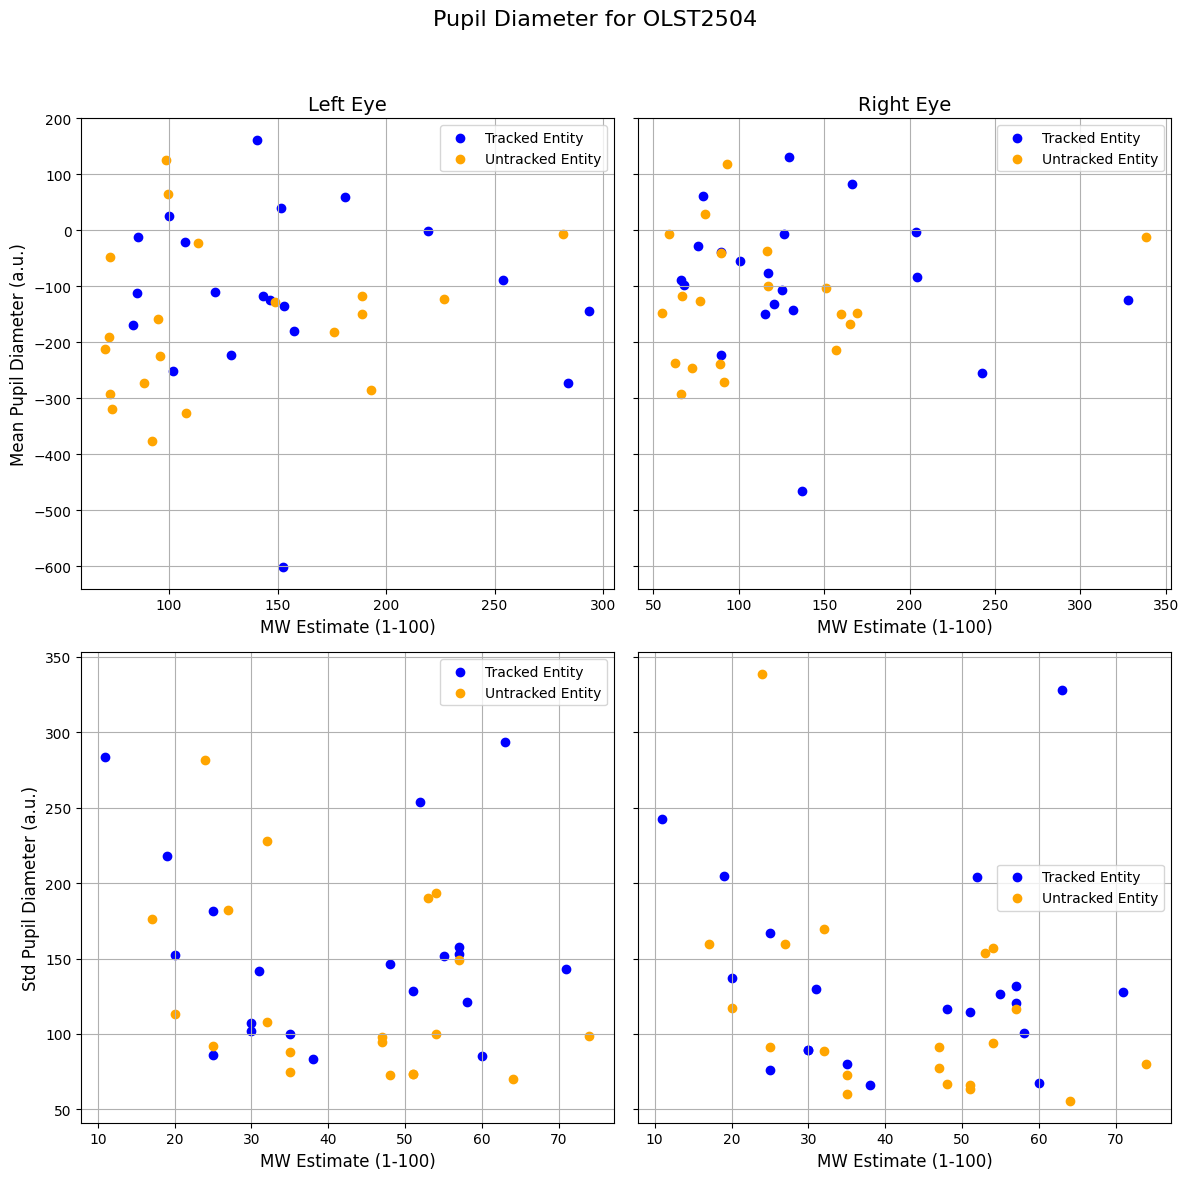

In [ ]:
def scatterResults(Results, entityTracked, pdf=None):
    """
    Plots pupil diameter for tracked and untracked entities in a 2x2 grid.
    
    Parameters:
    - Results: List of results to plot (e.g., [resultsL, resultsR, resultsL2, resultsR2]).
    - entityTracked: Name of the tracked entity.
    - pdf: PdfPages object to save the plots (optional).
    """
    fig, axs = plt.subplots(2, 2, figsize=(12, 12),sharey='row')
    plt.suptitle(f"Pupil Diameter for {entityTracked}", fontsize=16)

    # Titles for subplots
    row_titles = ["Mean", "Std",'diff']
    col_titles = ["Left Eye", "Right Eye"]

    for row in range(2):  # Rows: Mean vs. Std
        for col in range(2):  # Columns: Left Eye vs. Right Eye
            ax = axs[row, col]
            result = Results[row * 2 + col]  # Select the correct result (e.g., resultsL, resultsR, resultsL2, resultsR2)

            # Scatter plot for tracked and untracked entities
            ax.scatter(result[::2, 1], result[::2, 0], label="Tracked Entity", color="blue")
            ax.scatter(result[1::2, 1], result[1::2, 0], label="Untracked Entity", color="orange")

            # Set titles, labels, and grid
            if row == 0:
                ax.set_title(col_titles[col], fontsize=14)
            if col == 0:
                ax.set_ylabel(f"{row_titles[row]} Pupil Diameter (a.u.)", fontsize=12)
            ax.set_xlabel("MW Estimate (1-100)", fontsize=12)
            ax.legend()
            ax.grid(True)

    # Adjust layout to ensure everything fits
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Add space for the title

    if pdf is not None:
        pdf.savefig(fig)
    plt.show()

scatterResults([resultsL,resultsR,resultsL2,resultsR2],filename)

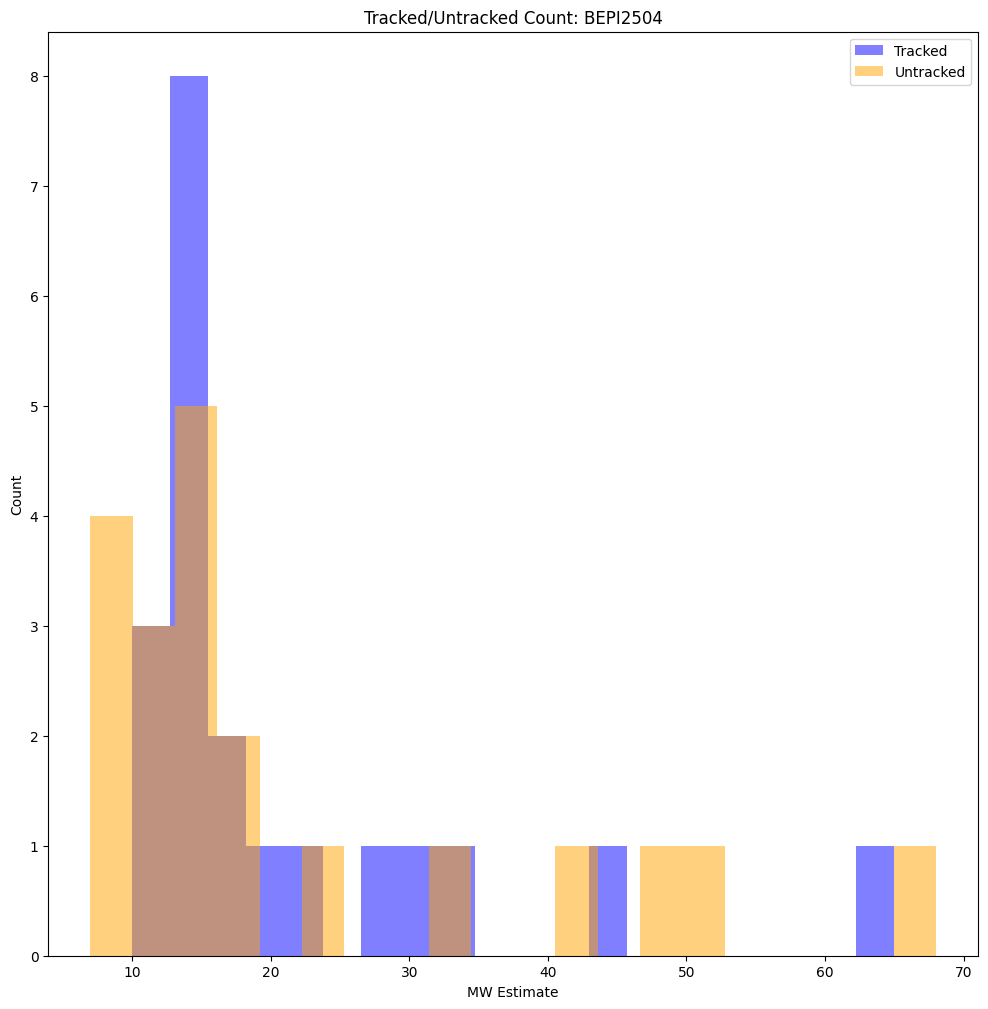

In [ ]:

def mwHist(resultsDF,filename):
    plt.figure(figsize=(12,12))
    plt.title(f'Tracked/Untracked Count: {filename}')
    plt.hist(resultsDF[resultsDF['Tracking'] == 'TRACKED']['MW Estimate'], bins=20,
            label='Tracked', alpha=0.5,color='blue')  # Set alpha to 0.5 for transparency
    plt.hist(resultsDF[resultsDF['Tracking'] == 'UNTRACKED']['MW Estimate'], bins=20, 
            label='Untracked', alpha=0.5,color='orange') # Set alpha to 0.5 for transparency
    plt.legend()
    plt.xlabel('MW Estimate')
    plt.ylabel('Count')
    plt.show()
mwHist(resultsDF,filename)

In [15]:


def wilcTest(x,y,verbose=0,analysisName=''):
    """
    Perform Wilcoxon signed-rank test on two paired samples.
    """
    from scipy.stats import wilcoxon
    stat, p = wilcoxon(x, y)

    diff = y - x

    ### Compute Zvalue 
    # Remove zero differences (as scipy does)
    non_zero_diff = diff[diff != 0]

    # n = number of non-zero diffs
    n = len(non_zero_diff)

    # Expected value and standard deviation under null
    mean_T = n * (n + 1) / 4
    std_T = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)

    # Compute z-score
    z = (stat - mean_T) / std_T
    if verbose:
        print(f"---- Signed-rank test results  for {analysisName}: ----")
        print(f"Wilcoxon signed-rank test statistic: {stat}")
        print(f"p-value: {p}")
        print(f"Z-score: {z}\n")


    return stat, p,z



##### (1) WILCOXON TESTIN TRACKED VS UNTRACKED 


from scipy.stats import ttest_ind, wilcoxon
def wilcLoop(resultsDF):
    p =  []
    z = []
    s = []
    anName = []
    parts = []
    modes = []
    eyes = []

    for part in ['first','second','All']:
        if part == 'first':
            cutt = slice(0, len(resultsDF) //4)  
        elif part == 'second':
            cutt =  slice(len(resultsDF) // 4, len(resultsDF)//2)
        elif part == 'All':
            cutt = slice(0, len(resultsDF)//2) 

        resPMW_W = wilcTest(resultsDF[resultsDF['Tracking'] == 'TRACKED']['MW Estimate'].iloc[cutt],
                            resultsDF[resultsDF['Tracking'] == 'UNTRACKED']['MW Estimate'].iloc[cutt],
                            verbose,analysisName='MW Estimate')
        p.append(resPMW_W[1])
        z.append(resPMW_W[2])
        s.append(resPMW_W[0])
        anName.append('MW Estimate')
        parts.append(part)
        modes.append('')
        eyes.append('')
        for j,mode in enumerate(['Mean','Std','diff']):
        
            

            for i,eye in enumerate(['Left Eye','Right Eye']):
                
                print(f"\nTests for Eye: {eye} and Estim Type {mode}")
                print("==="*20)
                if entityTracked == 'Karolina': # She is the First Entity
                    resPD_W  = wilcTest(resultsDF[resultsDF['Tracking'] == 'TRACKED']['Pupil Diameter'][mode][eye].iloc[cutt],
                                        resultsDF[resultsDF['Tracking'] == 'UNTRACKED']['Pupil Diameter'][mode][eye].iloc[cutt],
                                        verbose,analysisName='Pupil Diameter')
                

                else:
                    resPD_W  = wilcTest(resultsDF[resultsDF['Tracking'] == 'TRACKED']['Pupil Diameter'][mode][eye].iloc[cutt],
                                        resultsDF[resultsDF['Tracking'] == 'UNTRACKED']['Pupil Diameter'][mode][eye].iloc[cutt],
                                        verbose,analysisName='Pupil Diameter')
                p.append(resPD_W[1])
                z.append(resPD_W[2])
                s.append(resPD_W[0])
                anName.append('Pupil Diameter')
                parts.append(part)
                modes.append(mode)
                eyes.append(eye)

        stats_df = pd.DataFrame({
            'Statistic': s,
            'p-value': p,
            'Z-score': z
        })

    # Create a MultiIndex DataFrame
    index = pd.MultiIndex.from_arrays([ anName, parts, modes, eyes], names=['Analysis Name', 'Part', 'Mode', 'Eye'])
    stats_df = pd.DataFrame({'Statistic': s, 'p-value': p, 'Z-score': z}, index=index)

    # Display the DataFrame
    pd.set_option('display.max_rows', 50)

    stats_df.sort_values(by=['Analysis Name'], inplace=True)
    print(index)
    return stats_df,[ anName, parts, modes, eyes],s,p,z

[ stats_df, join,s,p,z] = wilcLoop(resultsDF)

stats_df

---- Signed-rank test results  for MW Estimate: ----
Wilcoxon signed-rank test statistic: 2.0
p-value: 1.0
Z-score: -3.8452649736747704


Tests for Eye: Left Eye and Estim Type Mean
---- Signed-rank test results  for Pupil Diameter: ----
Wilcoxon signed-rank test statistic: 15.0
p-value: 0.232421875
Z-score: -3.3599402682595083


Tests for Eye: Right Eye and Estim Type Mean
---- Signed-rank test results  for Pupil Diameter: ----
Wilcoxon signed-rank test statistic: 11.0
p-value: 0.10546875
Z-score: -3.5092709468488197


Tests for Eye: Left Eye and Estim Type Std
---- Signed-rank test results  for Pupil Diameter: ----
Wilcoxon signed-rank test statistic: 24.0
p-value: 0.76953125
Z-score: -3.023946241433557


Tests for Eye: Right Eye and Estim Type Std
---- Signed-rank test results  for Pupil Diameter: ----
Wilcoxon signed-rank test statistic: 27.0
p-value: 1.0
Z-score: -2.9119482324915738


Tests for Eye: Left Eye and Estim Type diff
---- Signed-rank test results  for Pupil Diameter: --

Statistic   p-value   Z-score
Analysis Name  Part   Mode Eye                                     
MW Estimate    first                        2.0  1.000000 -3.845265
               All                         20.0  0.218272 -5.242106
               second                      10.5  0.390625 -3.527937
Pupil Diameter All    Std  Right Eye       95.0  0.728506 -4.234009
                           Left Eye        95.0  0.728506 -4.234009
                      Mean Right Eye       73.0  0.245487 -4.529717
                           Left Eye        80.0  0.368277 -4.435628
               second diff Right Eye       26.0  0.921875 -2.949281
                           Left Eye        23.0  0.695312 -3.061279
                      Std  Right Eye       23.0  0.695312 -3.061279
                           Left Eye        20.0  0.492188 -3.173277
                      Mean Right Eye       25.0  0.845703 -2.986614
                           Left Eye        27.0  1.000000 -2.911948
               first  diff Right Eye       27.0  1.000000 -2.911948
                           Left Eye        27.0  1.000000 -2.911948
                      Std  Right Eye       27.0  1.000000 -2.911948
                           Left Eye        24.0  0.769531 -3.023946
                      Mean Right Eye       11.0  0.105469 -3.509271
                           Left Eye        15.0  0.232422 -3.359940
               All    diff Left Eye        96.0  0.756166 -4.220567
                           Right Eye      100.0  0.869488 -4.166802

In [ ]:
join

[['MW Estimate',
  'Pupil Diameter',
  'Pupil Diameter',
  'Pupil Diameter',
  'Pupil Diameter',
  'Pupil Diameter',
  'Pupil Diameter',
  'MW Estimate',
  'Pupil Diameter',
  'Pupil Diameter',
  'Pupil Diameter',
  'Pupil Diameter',
  'Pupil Diameter',
  'Pupil Diameter',
  'MW Estimate',
  'Pupil Diameter',
  'Pupil Diameter',
  'Pupil Diameter',
  'Pupil Diameter',
  'Pupil Diameter',
  'Pupil Diameter'],
 ['first',
  'first',
  'first',
  'first',
  'first',
  'first',
  'first',
  'second',
  'second',
  'second',
  'second',
  'second',
  'second',
  'second',
  'All',
  'All',
  'All',
  'All',
  'All',
  'All',
  'All'],
 ['',
  'Mean',
  'Mean',
  'Std',
  'Std',
  'diff',
  'diff',
  '',
  'Mean',
  'Mean',
  'Std',
  'Std',
  'diff',
  'diff',
  '',
  'Mean',
  'Mean',
  'Std',
  'Std',
  'diff',
  'diff'],
 ['',
  'Left Eye',
  'Right Eye',
  'Left Eye',
  'Right Eye',
  'Left Eye',
  'Right Eye',
  '',
  'Left Eye',
  'Right Eye',
  'Left Eye',
  'Right Eye',
  'Left Eye',

In [ ]:
s

[np.float64(2.0),
 np.float64(18.0),
 np.float64(17.0),
 np.float64(25.0),
 np.float64(26.0),
 np.float64(24.0),
 np.float64(27.0),
 np.float64(10.5),
 np.float64(21.0),
 np.float64(17.0),
 np.float64(15.0),
 np.float64(21.0),
 np.float64(22.0),
 np.float64(16.0),
 np.float64(20.0),
 np.float64(100.0),
 np.float64(104.0),
 np.float64(85.0),
 np.float64(95.0),
 np.float64(98.0),
 np.float64(91.0)]

In [ ]:
anName

NameError: name 'anName' is not defined

In [ ]:
import pandas as pd

# Export DataFrame to Excel as a new sheet
def save_df_to_excel(df, filename, sheet_name="Stats"):
    with pd.ExcelWriter(filename, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
        df.to_excel(writer, sheet_name=sheet_name)
# Save stats_df to Excel
save_df_to_excel(stats_df, os.path.join(workingDir,'individuals','analysis_results.xlsx'), sheet_name="Stats")

NameError: name 'stats_df' is not defined

In [ ]:
#### Stats of Introspecitve Probes: 
log_file = open(os.path.join(workingDir,filename,filename+"_analysisLog.txt"),'w+')

log_file.write(" "*15+"="*58 + "\n")
log_file.write(" "*15+"="*5+ " "*15+" PREPROC LOG FILE"+ " "*15+"="*5+ " \n")
log_file.write(" "*15+"="*58 + "\n\n")
log_file.write("\n===# General Info: #=== \n\n")

MBevents = event_dfs[event_dfs["key"] == 'MB']
TRTevents = event_dfs[event_dfs["key"] == 'TRT']
FOCUSevents = event_dfs[event_dfs["key"] == 'FOCUS']
MWevents = event_dfs[event_dfs["key"] == 'MW']

log_file.write( "\n                 Pupil Std Stats:\n")
log_file.write( "\n                N:    Mean:    Std: \n")
log_file.write(f"     MW       {len(MWevents):4.1f}    {np.mean(meanPupilMW):4.1f}    {np.std(meanPupilMW):4.1f}\n")
log_file.write(f"     FOCUS    {len(FOCUSevents):4.1f}    {np.mean(meanPupilFOCUS):4.1f}    {np.std(meanPupilFOCUS):4.1f}\n")
log_file.write(f"     TRT      {len(TRTevents):4.1f}    {np.mean(meanPupilTUT):4.1f}    {np.std(meanPupilTUT):4.1f}\n")
log_file.write(f"     MB       {len(MBevents):4.1f}    {np.mean(meanPupilMB):4.1f}    {np.std(meanPupilMB):4.1f}\n")


print( "                 Pupil Std Stats:")
print( "                N:    Mean:    Std: ")
print(f"     MW       {len(MWevents):4.1f}    {np.mean(meanPupilMW):4.1f}    {np.std(meanPupilMW):4.1f}")
print(f"     FOCUS    {len(FOCUSevents):4.1f}    {np.mean(meanPupilFOCUS):4.1f}    {np.std(meanPupilFOCUS):4.1f}")
print(f"     TRT      {len(TRTevents):4.1f}    {np.mean(meanPupilTUT):4.1f}    {np.std(meanPupilTUT):4.1f}")
print(f"     MB       {len(MBevents):4.1f}    {np.mean(meanPupilMB):4.1f}    {np.std(meanPupilMB):4.1f}")

log_file.close()

                 Pupil Std Stats:
                N:    Mean:    Std: 
     MW        2.0    380.3     0.0
     FOCUS    26.0    301.2    91.4
     TRT      16.0    306.7    76.3
     MB        0.0     nan     nan


C:\Users\barak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\barak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\barak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\barak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value enco

,beg,end,keytime
count,4.400000e+01,4.400000e+01,4.400000e+01
mean,2.045883e+06,2.105687e+06,2.107962e+06
std,1.457130e+06,1.456601e+06,1.456672e+06
min,1.160000e+02,6.143900e+04,6.569800e+04
25%,6.788725e+05,7.415155e+05,7.431022e+05
50%,2.048563e+06,2.107579e+06,2.110059e+06
75%,3.419564e+06,3.478465e+06,3.481546e+06
max,4.081365e+06,4.140232e+06,4.142164e+06
